In [7]:
from numpy.linalg import norm
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from sklearn.datasets import load_iris
from sklearn.datasets import load_svmlight_file
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.validation import check_is_fitted, check_array, check_X_y, check_random_state
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import ParameterGrid,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

from LMNN import LargeMarginNearestNeighbor
from LMNN_SS import SemiSupervisedLargeMarginNearestNeighbor

# from LMNN_loss_saved import LargeMarginNearestNeighbor
# from LMNN_SS_loss_saved import SemiSupervisedLargeMarginNearestNeighbor

import time
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, PCA
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Proof Of Concept on synthetic data

In [8]:
# first class
n = 50
x2_1 = np.linspace(-1,1,n)
x1_1 = np.random.normal(-0.05, 0.01, n)
y1 = np.repeat(1,n)
X1 = np.column_stack((x1_1,x2_1))

# second class
x2_2 = np.linspace(-1,1,n)
x1_2 = np.random.normal(0.05, 0.01, n)
y2 = np.repeat(2,n)
X2 = np.column_stack((x1_2,x2_2))

# as one data frame
X_proof = np.concatenate((X1,X2),axis=0)
Y_proof = np.concatenate((y1,y2))

color = np.concatenate((np.repeat('red',n),np.repeat('blue',n)))

# train an LMNN with different omegas
# takes SOME time
lmnn_0 = LargeMarginNearestNeighbor(n_neighbors=5,omega = 0.001)
lmnn_0.fit(X_proof,Y_proof)
X_proof_transformed_0 = lmnn_0.transform(X_proof)

lmnn_05 = LargeMarginNearestNeighbor(n_neighbors=5,omega = 0.5)
lmnn_05.fit(X_proof,Y_proof)
X_proof_transformed_05 = lmnn_05.transform(X_proof)

lmnn_1 = LargeMarginNearestNeighbor(n_neighbors=5,omega = 0.999)
lmnn_1.fit(X_proof,Y_proof)
X_proof_transformed_1 = lmnn_1.transform(X_proof)

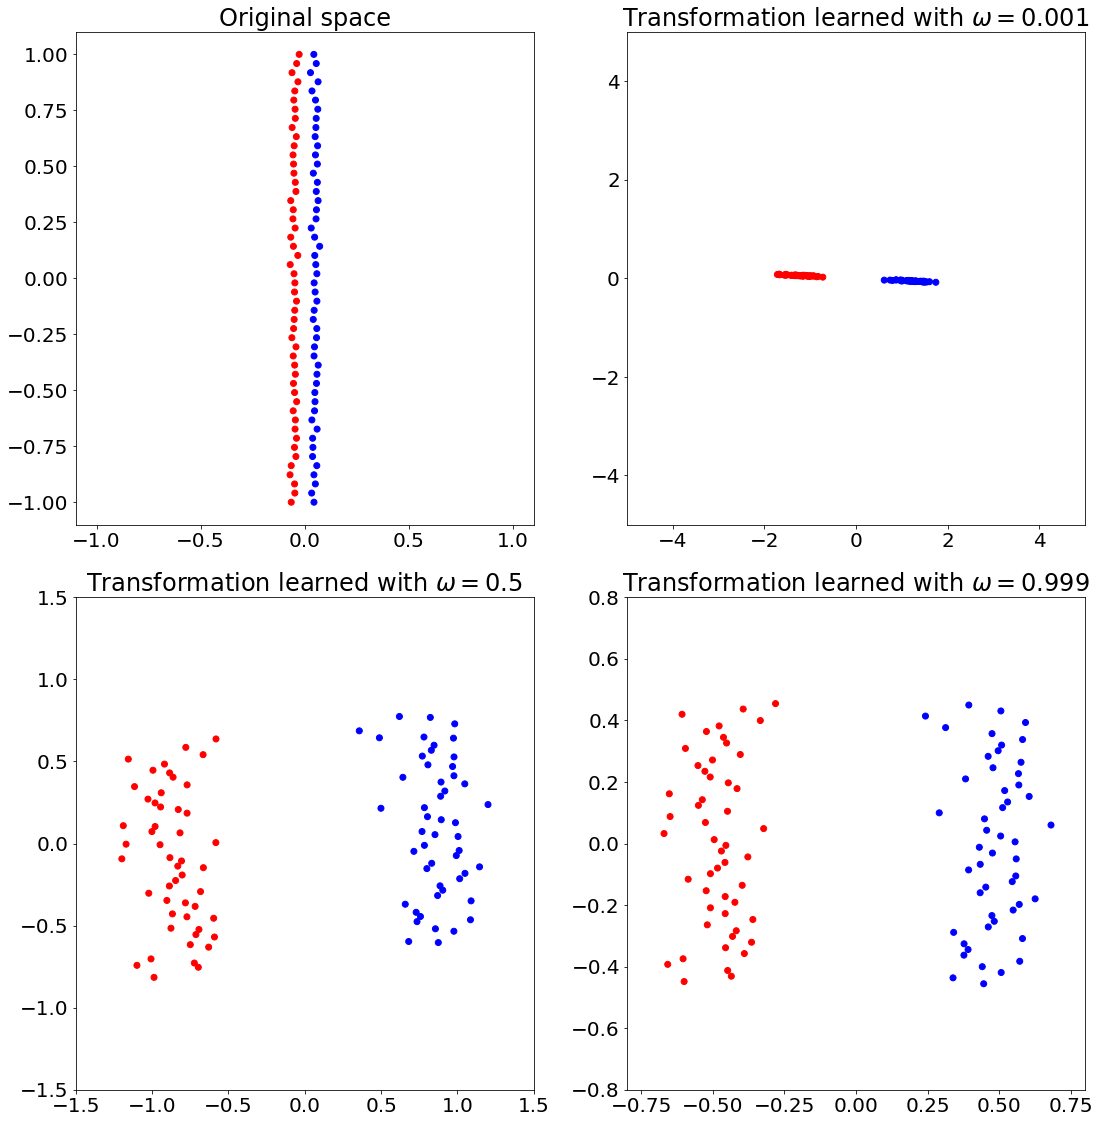

In [9]:
plt.rc('font', size=20)
# plot original and transformed together
plt.figure(1,figsize=(16,16))
plt.subplot(221)
plt.scatter(X_proof[:,0],X_proof[:,1],color=color)
plt.title('Original space')
scale1 = 1.1
plt.xlim(-scale1,scale1)
plt.ylim(-scale1,scale1)

plt.subplot(222)
plt.scatter(X_proof_transformed_0[:,0],X_proof_transformed_0[:,1],color=color)
plt.title('Transformation learned with $\omega = 0.001$')
scale2 = 5
plt.xlim(-scale2,scale2)
plt.ylim(-scale2,scale2)

plt.subplot(223)
plt.scatter(X_proof_transformed_05[:,0],X_proof_transformed_05[:,1],color=color)
plt.title('Transformation learned with $\omega = 0.5$')
scale3 = 1.5
plt.xlim(-scale3,scale3)
plt.ylim(-scale3,scale3)

plt.subplot(224)
plt.scatter(X_proof_transformed_1[:,0],X_proof_transformed_1[:,1],color=color)
plt.title('Transformation learned with $\omega = 0.999$')
scale4 = 0.8
plt.xlim(-scale4,scale4)
plt.ylim(-scale4,scale4)

plt.tight_layout()
# plt.savefig('best_synth_space_transform')
plt.show()

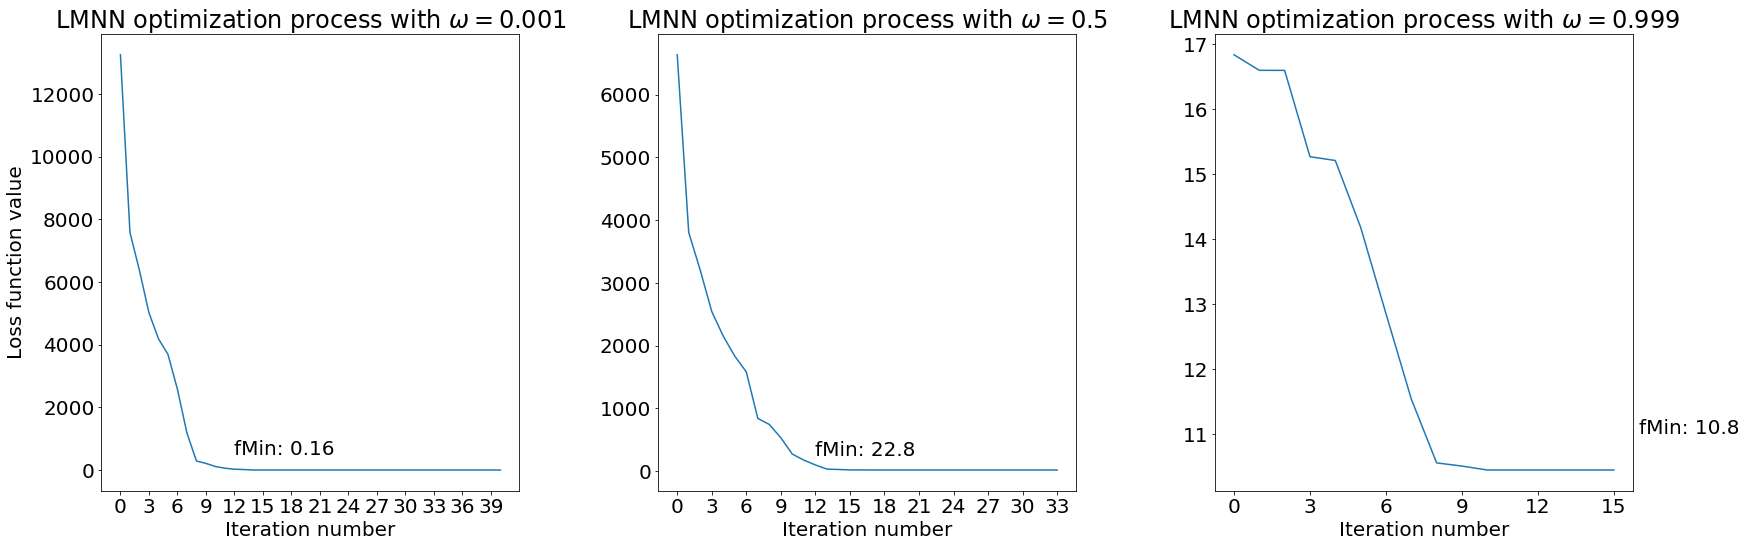

In [12]:
plt.rc('font', size=20)
plt.figure(1,figsize=(24,8))

plt.subplot(131)
plt.plot(lmnn_0.iter_progres)
plt.title('LMNN optimization process with $\omega = 0.001$')
plt.ylabel('Loss function value')
plt.xlabel('Iteration number')
plt.xticks(np.arange(0, lmnn_0.iter_progres.shape[0], step=3))
plt.text(12, 500,'fMin: 0.16', fontsize = 20)

plt.subplot(132)
plt.plot(lmnn_05.iter_progres)
plt.title('LMNN optimization process with $\omega = 0.5$')
# plt.ylabel('Loss function value')
plt.xlabel('Iteration number')
plt.xticks(np.arange(0, lmnn_05.iter_progres.shape[0], step=3))
plt.text(12, 250,'fMin: 22.8', fontsize = 20)

plt.subplot(133)
plt.plot(lmnn_1.iter_progres)
plt.title('LMNN optimization process with $\omega = 0.999$')
# plt.ylabel('Loss function value')
plt.xlabel('Iteration number')
plt.xticks(np.arange(0, lmnn_1.iter_progres.shape[0], step=3))
plt.text(16, 11,'fMin: 10.8', fontsize = 20)

plt.tight_layout()
# plt.savefig('best_synth_convergence')
plt.show()

In [13]:
print('Omega 0.001, fMin:',np.min(lmnn_0.iter_progres),'Decrease from initial:',
      np.max(lmnn_0.iter_progres)/np.min(lmnn_0.iter_progres),'times')

print('Omega 0.5, fMin:',np.min(lmnn_05.iter_progres),'Decrease from initial:',
      np.max(lmnn_05.iter_progres)/np.min(lmnn_05.iter_progres),'times')

print('Omega 0.999, fMin:',np.min(lmnn_1.iter_progres),'Decrease from initial:',
      np.max(lmnn_1.iter_progres)/np.min(lmnn_1.iter_progres),'times')

Omega 0.001, fMin: 0.0510114189052 Decrease from initial: 259886.352457 times
Omega 0.5, fMin: 15.8362954964 Decrease from initial: 419.100808226 times
Omega 0.999, fMin: 10.4478996011 Decrease from initial: 1.61150962885 times


## Experiment - USPS image transformations

In [14]:
def get_USPS_training_data():
    data = load_svmlight_file('ml_data/usps/usps')
    return data[0], data[1]

def get_USPS_testing_data():
    data = load_svmlight_file('ml_data/usps/usps.t')
    return data[0], data[1]

X_train, y_train = get_USPS_training_data()
X_test, y_test = get_USPS_testing_data()

######## Sample label, unlabel set  from training #########
X_train=np.asarray(X_train.todense())
y_train=np.asarray(y_train)
X_test=np.asarray(X_test.todense())
y_test=np.asarray(y_test)

sample_inds=np.random.randint(X_train.shape[0], size=200)
X_train_labelled=X_train[sample_inds, :]
y_train_labelled=y_train[sample_inds]

X_train_unlabelled_base = np.delete(X_train, sample_inds,0)
y_train_unlabelled_base = np.delete(y_train, sample_inds,0)

In [22]:
# fit LMNN and SS-LMNN models

k = 10
omega0 = 0.1
omega1 = 0.1
omega2 = 0.7

lmnn = LargeMarginNearestNeighbor(n_neighbors=k,omega = omega0,max_iter=2)
lmnn.fit(X_train_labelled,y_train_labelled)
print("LMNN : ", lmnn.score(X_test,y_test))

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled,y_train_labelled)
print("KNN : ", neigh.score(X_test,y_test))

# ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0 = omega0, omega1 = omega1, omega2 = omega2)
# ssc.fit(X_train_labelled, X_train_unlabelled_base, y_train_labelled)

LMNN :  0.841554559043
KNN :  0.750871948181


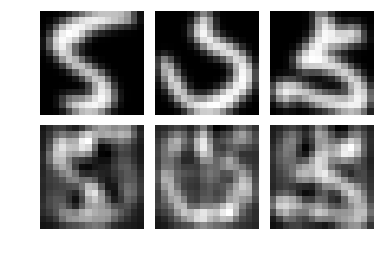

In [23]:
# plot transformations

n = 3
y_values = np.unique(y_train_labelled)
y = y_values[5]

relevant_x_test_indexes = np.where(y_test == y)[0]
selected_ind = np.random.choice(relevant_x_test_indexes, n, replace=False)
selected_x = X_test[selected_ind,:]

selected_x_transformed_lmnn = lmnn.transform(selected_x)
# selected_x_transformed_ssc = ssc.transform(selected_x)

for i in range(n):
    # original image
    plt.subplot(2,n,(1 + i))
    x_original = selected_x[i,:]
    x_original = np.reshape(x_original,(16,16))
    plt.imshow(x_original,'gray')
    plt.axis('off')
    # lmnn_transformed image
    plt.subplot(2,n,(1+n + i))
    x_lmnn = selected_x_transformed_lmnn[i,:]
    x_lmnn = np.reshape(x_lmnn,(16,16))
    plt.imshow(x_lmnn,'gray')
    plt.axis('off')
    # ss-lmnn transformed image
#     plt.subplot(3,n,(7 + i))
#     x_ssc = selected_x_transformed_ssc[i,:]
#     x_ssc = np.reshape(x_ssc,(16,16))
#     plt.imshow(x_ssc,'gray')
#     plt.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.title('Learned tranformation for USPS dataset')
# plt.savefig('USPS_transformation.png',dpi=900)
plt.show()

## Experiment - Sign Language Digits image transformations

In [24]:
# load base data
X = np.load('ml_data/Sign-language-digits-dataset/X.npy')
Y = np.load('ml_data/Sign-language-digits-dataset/Y.npy')
X = X.reshape((X.shape[0], X.shape[1]**2))
Y = np.argwhere(Y == 1)[:,1]

In [25]:
# Do PCA on it to reduce dimensions
pca = PCA(n_components=X.shape[1])
pca.fit(X)
explained = np.cumsum(pca.explained_variance_ratio_ )
print("First 200 components explain " + str(explained[200]) + " of varuance")

pca_second = PCA(n_components=200)
pca_second.fit(X)
X_redux = pca_second.fit_transform(X)

First 200 components explain 0.912779597107 of varuance


In [26]:
# sample into train and test datasets
train_test_sample_inds=np.random.randint(X.shape[0], size=100)

X_test = X_redux[train_test_sample_inds]
y_test = Y[train_test_sample_inds]

X_train = np.delete(X_redux, train_test_sample_inds,0)
y_train = np.delete(Y, train_test_sample_inds,0)


######## Sample label, unlabel set  from training #########
# keeping 1 to 20 ration of unlabeled to laneled data
sample_inds=np.random.randint(X_train.shape[0], size=200)
X_train_labelled=X_train[sample_inds,:]
y_train_labelled=y_train[sample_inds]

new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

sample_inds=np.random.randint(new_X_train.shape[0], size=new_X_train.shape[0])
X_train_unlabelled=new_X_train[sample_inds,:]

In [27]:
# fit LMNN

k = 4
omega0 = 0.1
omega1 = 0.1
omega2 = 0.7

# note to k = 10 and max_iter = 500 setting: long execution time, but VERY nice convergence on optimizer
# although the test performance is... no better than KNN
# obviously these omega params are not optimal for this dataset
# do the CV later????
lmnn = LargeMarginNearestNeighbor(n_neighbors=k,omega = omega0,max_iter=500)
lmnn.fit(X_train_labelled,y_train_labelled)
print("LMNN : ", lmnn.score(X_test,y_test))

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled,y_train_labelled)
print("KNN : ", neigh.score(X_test,y_test))

# more effective than KNN !
ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0=omega0, omega1=omega1, omega2=omega2, 
                                               X_unlabeled=X_train_unlabelled, max_iter = 500 )
ssc.fit(X_train_labelled, y_train_labelled)
print("SS-LMNN : ", ssc.score(X_test,y_test))

LMNN :  0.28
KNN :  0.38
SS-LMNN :  0.45


Amount of image classes :  (10,)
Transformed image set shape :  (3, 4096)
Image set shape :  (3, 4096)


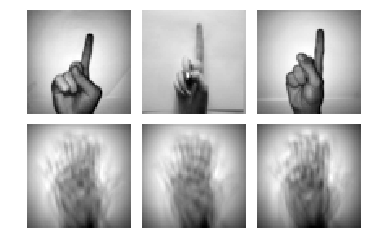

In [75]:
# plot transformations
n = 3
y_values = np.unique(y_train_labelled)
y = y_values[4]

relevant_x_indexes = np.where(Y == y)[0]
selected_ind = np.random.choice(relevant_x_indexes, n, replace=False)
selected_x = X[selected_ind,:]

selected_x_pca = pca_second.transform(selected_x)
selected_x_pca_lmnn = ssc.transform(selected_x_pca)

selected_x_pca_lmm_original = pca_second.inverse_transform(selected_x_pca_lmnn)

print("Amount of image classes : ", y_values.shape)
print("Transformed image set shape : ", selected_x_pca_lmm_original.shape)
print("Image set shape : ", selected_x.shape)

for i in range(n):
    # original image
    plt.subplot(2,n,(1 + i))
    x_original = selected_x[i,:]
    x_original = np.reshape(x_original,(64,64))
    plt.imshow(x_original,'gray')
    plt.axis('off')
    # lmnn_transformed image
    plt.subplot(2,n,(1+n + i))
    x_lmnn = selected_x_pca_lmm_original[i,:]
    x_lmnn = np.reshape(x_lmnn,(64,64))
    plt.imshow(x_lmnn,'gray')
    plt.axis('off')
    # ss-lmnn transformed image
#     plt.subplot(3,n,(7 + i))
#     x_ssc = selected_x_transformed_ssc[i,:]
#     x_ssc = np.reshape(x_ssc,(16,16))
#     plt.imshow(x_ssc,'gray')
#     plt.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('Sign_Language_Digits_transformation.png',dpi=900)
plt.show()